In [1]:
import numpy as np
import pandas as pd
from pycytominer.cyto_utils import infer_cp_features
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../scripts")
from utils import load_data
from tensorflow import keras
from scipy.stats import pearsonr, ttest_ind, ttest_1samp

import seaborn
from sklearn.decomposition import PCA
import random

In [2]:
np.random.seed(82)
NUM_RANDOM_SAMPLES = 10

In [3]:
data_dict = load_data(["complete"])
meta_features = infer_cp_features(data_dict["complete"], metadata=True)
cp_features = infer_cp_features(data_dict["complete"])

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [4]:
latent_dim = 10
latent_space_columns = np.arange(0,latent_dim)
latent_space_columns = [str(latent_space_column) for latent_space_column in latent_space_columns]

In [5]:
latent_df = pd.read_csv("level5Latent_mmd.csv").drop("Unnamed: 0", axis = 1)
pca = PCA(n_components=latent_dim)
pca_latent_df = pd.DataFrame(pca.fit_transform(complete_features_df), columns = latent_space_columns)

In [6]:
moa_df = pd.read_csv("repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=complete_meta_df['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
meta_moa_latent_df = pd.concat([complete_meta_df,moa_df,latent_df], axis=1)
meta_moa_pca_latent_df = pd.concat([complete_meta_df,moa_df,pca_latent_df], axis=1)
meta_moa_complete_df = pd.concat([complete_meta_df,moa_df,complete_features_df], axis=1)

# fill negative control DMSO profiles, change the NaN MOA label to be DMSO
meta_moa_latent_df.loc[meta_moa_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_pca_latent_df.loc[meta_moa_pca_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_complete_df.loc[meta_moa_complete_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'

#drop profiles with NaN MOAs
meta_moa_latent_df = meta_moa_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_pca_latent_df = meta_moa_pca_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_complete_df = meta_moa_complete_df.dropna(subset=['moa']).reset_index(drop = True)

# add columns to the dataframe that are randomnly shuffled permutations of the MOA column
for i in range(NUM_RANDOM_SAMPLES):
    random_moa_labels = pd.DataFrame([meta_moa_latent_df.moa.sample(frac=1)]).transpose().reset_index().drop('index', axis = 1)
    random_moa_labels = random_moa_labels.rename(columns={'moa': 'random_moa_labels' + str(i)})

    meta_moa_latent_df = pd.concat([random_moa_labels, meta_moa_latent_df], axis=1)
    meta_moa_pca_latent_df = pd.concat([random_moa_labels, meta_moa_pca_latent_df], axis=1)

    meta_moa_complete_df = pd.concat([random_moa_labels, meta_moa_complete_df], axis=1)

meta_moa_complete_df.head()

,random_moa_labels9,random_moa_labels8,random_moa_labels7,random_moa_labels6,random_moa_labels5,random_moa_labels4,random_moa_labels3,random_moa_labels2,random_moa_labels1,random_moa_labels0,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,retinoid receptor agonist,transthyretin amyloid inhibitor,androgen receptor antagonist,serotonin receptor antagonist,retinoid receptor agonist,DMSO,androgen receptor modulator,proteasome inhibitor,adrenergic receptor antagonist,SYK inhibitor,...,0.164260,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,phosphodiesterase inhibitor,topoisomerase inhibitor,calcium channel blocker,beta lactamase inhibitor,mTOR inhibitor|PI3K inhibitor,FGFR inhibitor|VEGFR inhibitor,NFkB pathway inhibitor|proteasome inhibitor,NFkB pathway inhibitor|proteasome inhibitor,topoisomerase inhibitor,NFkB pathway inhibitor|proteasome inhibitor,...,0.184110,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,glucokinase inhibitor,NFkB pathway inhibitor|proteasome inhibitor,histamine receptor antagonist,VEGFR inhibitor,DMSO,adrenergic receptor antagonist,Pim kinase inhibitor,kainate receptor antagonist,ATP channel activator|potassium channel activator,uricosuric blocker,...,0.175640,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086
3,leukotriene synthesis inhibitor|lipoxygenase i...,prostacyclin analog,nucleoside reverse transcriptase inhibitor,platelet aggregation inhibitor,WEE1 kinase inhibitor,DMSO,DMSO,dehydrogenase inhibitor,cyclooxygenase inhibitor,mTOR inhibitor|PI3K inhibitor,...,0.141310,0.18764,0.17342,0.18641,0.54696,0.44890,0.40042,0.30187,0.35082,0.32103
4,leukotriene receptor antagonist,opioid receptor agonist|opioid receptor antago...,protein synthesis inhibitor,DMSO,prostanoid receptor antagonist,carboxamide antiepileptic,PLK inhibitor,DNA inhibitor,phosphodiesterase inhibitor,adrenergic receptor antagonist,...,0.094635,0.16631,0.15218,0.15540,0.56882,0.46601,0.40149,0.31658,0.36167,0.33338


In [7]:
moas_occurrence = pd.read_csv("moas_occurrence.tsv", sep = "\t")
moas_occurrence.index = moas_occurrence['moa']
moas_occurrence = moas_occurrence.drop('moa', axis = 1)

#We only want moa combinations with enough data, so we pick A|B such that there are at least 5 A|B, 5 A, and 5 B.
valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] > 0) & (moas_occurrence['moa1 occurrence'] > 0)& (moas_occurrence['moa2 occurrence'] > 0)].index
valid_pipes = valid_pipes[valid_pipes.str.count("\|") == 1]

In [8]:
def subset_by_moa(pipe, df_name, column):
    moas = pipe.split("|")
    subset_df = pd.concat([df_name[df_name[column] == moas[0]],df_name[df_name[column] == moas[1]]])
    return subset_df

def LSA(A, B, D):
    return A-D+B

In [9]:
#calculate means for each A and B in each A|B.
subset_means = []
subset_random_means = []
subset_pca_means = []
subset_pca_random_means = []
subset_complete_means = []
subset_complete_random_means = []

for pipe in valid_pipes:
    subset = subset_by_moa(pipe, meta_moa_latent_df, 'moa')
    subset_mean = subset.groupby(['moa'])[latent_space_columns].mean()
    subset_pca = subset_by_moa(pipe, meta_moa_pca_latent_df, 'moa')
    subset_pca_mean = subset_pca.groupby(['moa'])[latent_space_columns].mean()
    subset_complete = subset_by_moa(pipe, meta_moa_complete_df, 'moa')
    subset_complete_mean = subset_complete.groupby(['moa'])[complete_features_df.columns].mean()
    
    
    subsets_random_mean = []
    subsets_pca_random_mean = []
    subsets_complete_random_mean = []
    for i in range(NUM_RANDOM_SAMPLES):
        label = 'random_moa_labels' + str(i)
        subset_random = subset_by_moa(pipe, meta_moa_latent_df, label)
        subset_random_mean = subset_random.groupby([label])[latent_space_columns].mean()
        subsets_random_mean.append(subset_random_mean)
        
        subset_pca_random = subset_by_moa(pipe, meta_moa_pca_latent_df, label)
        subset_pca_random_mean = subset_pca_random.groupby([label])[latent_space_columns].mean()
        subsets_pca_random_mean.append(subset_pca_random_mean)
        
        subset_complete_random = subset_by_moa(pipe, meta_moa_complete_df, label)
        subset_complete_random_mean = subset_complete_random.groupby([label])[complete_features_df.columns].mean()
        subsets_complete_random_mean.append(subset_complete_random_mean)
    
    subset_means.append(subset_mean)
    subset_pca_means.append(subset_pca_mean)
    subset_complete_means.append(subset_complete_mean)
    
    subset_random_means.append(subsets_random_mean)
    subset_pca_random_means.append(subsets_pca_random_mean)
    subset_complete_random_means.append(subsets_complete_random_mean)



In [10]:
#calculate means for DMSO
DMSO = meta_moa_latent_df[meta_moa_latent_df.moa == 'DMSO']
DMSO_pca = meta_moa_pca_latent_df[meta_moa_pca_latent_df.moa == 'DMSO']
DMSO_complete = meta_moa_complete_df[meta_moa_complete_df.moa == 'DMSO']

DMSO_means = np.mean(DMSO[latent_space_columns])
DMSO_means_pca = np.mean(DMSO_pca[latent_space_columns])
DMSO_means_complete = np.mean(DMSO_complete[complete_features_df.columns])


DMSO_means_random = []
DMSO_means_pca_random = []
DMSO_means_complete_random = []

for i in range(NUM_RANDOM_SAMPLES):
    label = 'random_moa_labels' + str(i)
    DMSO_random = meta_moa_latent_df[meta_moa_latent_df[label] == 'DMSO']
    DMSO_means_random.append(np.mean(DMSO_random[latent_space_columns]))

    DMSO_pca_random = meta_moa_pca_latent_df[meta_moa_pca_latent_df[label] == 'DMSO']
    DMSO_means_pca_random.append(np.mean(DMSO_pca_random[latent_space_columns]))
    
    DMSO_complete_random = meta_moa_complete_df[meta_moa_complete_df[label] == 'DMSO']
    DMSO_means_complete_random.append(np.mean(DMSO_complete_random[complete_features_df.columns]))

In [11]:
#perform latent space arithmetic
representations_after_LSA = []
representations_after_LSA_random = []
representations_after_LSA_pca = []
representations_after_LSA_pca_random = []
representations_after_LSA_complete = []
representations_after_LSA_complete_random = []


for i in range(len(subset_means)):
    representation_after_LSA = LSA(subset_means[i].loc[valid_pipes[i].split("|")[0]],subset_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means)
    representation_after_LSA = pd.DataFrame(representation_after_LSA).transpose()
    representations_after_LSA.append(representation_after_LSA)
    
    representation_after_LSA_pca = LSA(subset_pca_means[i].loc[valid_pipes[i].split("|")[0]],subset_pca_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means_pca)
    representation_after_LSA_pca = pd.DataFrame(representation_after_LSA_pca).transpose()
    representations_after_LSA_pca.append(representation_after_LSA_pca)
    
    representation_after_LSA_complete = LSA(subset_complete_means[i].loc[valid_pipes[i].split("|")[0]],subset_complete_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means_complete)
    representation_after_LSA_complete = pd.DataFrame(representation_after_LSA_complete).transpose()
    representations_after_LSA_complete.append(representation_after_LSA_complete)
    
    
    LSA_random_1pipe = []
    PCA_random_1pipe = []
    complete_random_1pipe = []
    for j in range(NUM_RANDOM_SAMPLES):
        representation_after_LSA_random = LSA(subset_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_random[j])
        representation_after_LSA_random = pd.DataFrame(representation_after_LSA_random).transpose()
        LSA_random_1pipe.append(representation_after_LSA_random)    

        representation_after_LSA_pca_random = LSA(subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_pca_random[j])
        representation_after_LSA_pca_random = pd.DataFrame(representation_after_LSA_pca_random).transpose()
        PCA_random_1pipe.append(representation_after_LSA_pca_random)
        
        representation_after_LSA_complete_random = LSA(subset_complete_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_complete_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_complete_random[j])
        representation_after_LSA_complete_random = pd.DataFrame(representation_after_LSA_complete_random).transpose()
        complete_random_1pipe.append(representation_after_LSA_complete_random)
        
    representations_after_LSA_random.append(LSA_random_1pipe)
    representations_after_LSA_pca_random.append(PCA_random_1pipe)
    representations_after_LSA_complete_random.append(complete_random_1pipe)


In [12]:
decoder = keras.models.load_model("../2.train/level5Decoder_mmd")


In [13]:
#decode each latent space representation

predictions = []
predictions_random = []
predictions_pca = []
predictions_pca_random = []
predictions_complete = []
predictions_complete_random = []

for i in range(len(representations_after_LSA)):
    predictions.append(decoder.predict(representations_after_LSA[i]))
    predictions_pca.append(pca.inverse_transform(representations_after_LSA_pca[i]))
    predictions_complete.append(representations_after_LSA_complete[i].values.tolist())
    
    predictions_random_1pipe = []
    predictions_pca_random_1pipe = []
    predictions_complete_random_1pipe = []
    for j in range(NUM_RANDOM_SAMPLES):
        predictions_random_1pipe.append(decoder.predict(representations_after_LSA_random[i][j]))
        predictions_pca_random_1pipe.append(pca.inverse_transform(representations_after_LSA_pca_random[i][j]))
        predictions_complete_random_1pipe.append(representations_after_LSA_complete_random[i][j].values.tolist())

    predictions_random.append(predictions_random_1pipe)
    predictions_pca_random.append(predictions_pca_random_1pipe)
    predictions_complete_random.append(predictions_complete_random_1pipe)
        
predictions = np.array(predictions)
predictions_random = np.array(predictions_random)
predictions_pca = np.array(predictions_pca)
predictions_pca_random = np.array(predictions_pca_random)
predictions_complete = np.array(predictions_complete)
predictions_complete_random = np.array(predictions_complete_random)

In [14]:
# meta_moa_complete_df.columns.to_list()

In [15]:
mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'Cells_AreaShape_FormFactor':]
mean_of_moas = mean_of_moas[mean_of_moas.index.str.contains('\|')]

In [16]:
# calculates all L2 distances for both per MOA combo and general distribution comparison for all MOA combos
L2 = []
L2_random = []
L2_pca = []
L2_pca_random = []
L2_complete = []
L2_complete_random = []


per_moa_pvalues_vae = []
per_moa_tstat_vae = []
per_moa_pvalues_pca = []
per_moa_tstat_pca = []
per_moa_pvalues_complete = []
per_moa_tstat_complete = []

for i in range(len(valid_pipes)):
    desired_moa = np.array(mean_of_moas[mean_of_moas.index == valid_pipes[i]])
    
    L2.append(np.linalg.norm(predictions[i][0]-desired_moa[0]))
    L2_pca.append(np.linalg.norm(predictions_pca[i][0]-desired_moa[0]))
    L2_complete.append(np.linalg.norm(predictions_complete[i][0]-desired_moa[0]))

    
    L2_random_per_moa = []
    L2_pca_random_per_moa = []
    L2_complete_random_per_moa = []
    for j in range(NUM_RANDOM_SAMPLES):
        L2_random_per_moa.append(np.linalg.norm(predictions_random[i][j][0]-desired_moa[0]))
        L2_pca_random_per_moa.append(np.linalg.norm(predictions_pca_random[i][j][0]-desired_moa[0]))
        L2_complete_random_per_moa.append(np.linalg.norm(predictions_complete_random[i][j][0]-desired_moa[0]))
    
    L2_random += L2_random_per_moa
    L2_pca_random += L2_pca_random_per_moa
    L2_complete_random += L2_complete_random_per_moa
    
    tstat_vae, pval_vae = ttest_1samp(L2_random_per_moa, np.linalg.norm(predictions[i][0]-desired_moa[0]))
    tstat_pca, pval_pca = ttest_1samp(L2_pca_random_per_moa, np.linalg.norm(predictions_pca[i][0]-desired_moa[0]))
    tstat_complete, pval_complete = ttest_1samp(L2_complete_random_per_moa, np.linalg.norm(predictions_complete[i][0]-desired_moa[0]))
        
    per_moa_pvalues_vae.append(pval_vae)
    per_moa_tstat_vae.append(tstat_vae)
    per_moa_pvalues_pca.append(pval_pca)
    per_moa_tstat_pca.append(tstat_pca)
    per_moa_pvalues_complete.append(pval_complete)
    per_moa_tstat_complete.append(tstat_complete)


In [17]:
per_moa_performance_df = pd.DataFrame({"MOA":valid_pipes,"vae pvalue":per_moa_pvalues_vae,"vae tstat":per_moa_tstat_vae,"pca pvalue":per_moa_pvalues_pca,"pca tstat":per_moa_tstat_pca})
per_moa_performance_df.to_csv('ttest_per_moa.tsv', sep = '\t')


In [18]:
per_moa_performance_df = per_moa_performance_df.sort_values('vae tstat')
per_moa_performance_df.to_csv('level5_moa_performance.csv')

In [19]:
well_predicted = per_moa_performance_df[per_moa_performance_df['vae tstat'] < 0]
well_predicted.to_csv('well_predicted_level5.csv')
well_predicted

,MOA,vae pvalue,vae tstat,pca pvalue,pca tstat
28,EGFR inhibitor|protein tyrosine kinase inhibitor,6.089314e-10,-27.127613,3.524337e-06,-10.018249
4,cyclooxygenase inhibitor|prostanoid receptor a...,1.300650e-09,-24.908451,3.979216e-01,0.887470
45,DNA synthesis inhibitor|thymidylate synthase i...,3.033750e-08,-17.436120,2.265186e-04,-5.909045
24,aromatase inhibitor|TRPV antagonist,2.984803e-06,-10.219892,1.635166e-07,-14.371457
46,apoptosis stimulant|ribonucleotide reductase i...,7.954707e-06,-9.078134,3.691484e-05,-7.500325
11,norepinephrine reputake inhibitor|tricyclic an...,9.278397e-06,-8.908894,2.944113e-02,-2.585268
69,acetylcholinesterase inhibitor|microtubule inh...,1.392154e-05,-8.475026,4.734045e-06,-9.668471
50,cyclooxygenase inhibitor|NFkB pathway inhibitor,4.536113e-05,-7.305854,9.179191e-02,-1.886884
31,CDK inhibitor|glycogen synthase kinase inhibitor,6.812856e-05,-6.932887,7.882546e-07,-11.967012
54,histamine receptor antagonist|platelet activat...,1.031212e-04,-6.567030,1.320145e-07,-14.730765


In [20]:
L2_df = pd.DataFrame(L2, columns = ['VAE Unshuffled'])
L2_random_df = pd.DataFrame(L2_random, columns = ['VAE Shuffled'])
L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
L2_complete_df = pd.DataFrame(L2_complete, columns = ['Complete Unshuffled'])
L2_complete_random_df = pd.DataFrame(L2_complete_random, columns = ['Complete Shuffled'])
L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df, L2_complete_df, L2_complete_random_df], ignore_index = True, axis = 1)
L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled','Complete Unshuffled','Complete Shuffled']
L2_df.to_csv('L2_general.tsv', sep = '\t')


# L2_df = pd.DataFrame(L2, columns = ['VAE Unshuffled'])
# L2_random_df = pd.DataFrame(L2_random, columns = ['VAE Shuffled'])
# L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
# L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
# L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df], ignore_index = True, axis = 1)
# L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled']
# L2_df.to_csv('L2_general.tsv', sep = '\t')

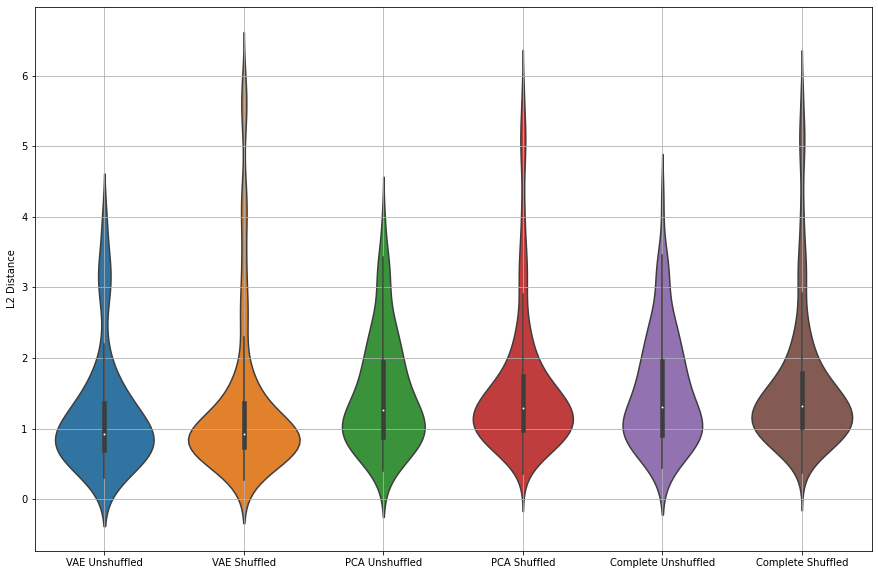

In [21]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(15, 10))
ax = seaborn.violinplot(data = L2_df)
ax.set(ylabel = "L2 Distance")
plt.grid()

plt.show()

In [22]:
L2_df.describe()

,VAE Unshuffled,VAE Shuffled,PCA Unshuffled,PCA Shuffled,Complete Unshuffled,Complete Shuffled
count,84.000000,840.000000,84.000000,840.000000,84.000000,840.000000
mean,1.216483,1.341284,1.501850,1.587793,1.547711,1.614556
std,0.828834,1.167586,0.782634,1.015541,0.795365,1.009502
min,0.306320,0.271299,0.398678,0.363183,0.441434,0.370953
25%,0.697860,0.736723,0.881700,0.980916,0.914178,1.018356
50%,0.932184,0.931719,1.264196,1.296486,1.309384,1.323627
75%,1.358485,1.368211,1.945271,1.750830,1.961255,1.782650
max,3.928693,6.009630,3.923328,5.835819,4.234526,5.834082


In [23]:
# computing a 2-tailed 2-sample t-test. In the paper, we compute the one-tailed p-value by dividing the follwing p-value by 2
print(ttest_ind(L2_df['VAE Unshuffled'].dropna(), L2_df['VAE Shuffled']))
print(ttest_ind(L2_df['PCA Unshuffled'].dropna(), L2_df['PCA Shuffled']))
print(ttest_ind(L2_df['Complete Unshuffled'].dropna(), L2_df['Complete Shuffled']))
#1.29
#1.51

Ttest_indResult(statistic=-0.9556394046658049, pvalue=0.33950493660622283)
Ttest_indResult(statistic=-0.7534341306626033, pvalue=0.4513814268248286)
Ttest_indResult(statistic=-0.5887733264746937, pvalue=0.5561575524408704)
